## 고양이 얼굴 바운딩 박스 찾기

robotflow 사이트 -> 실시간 이미지 segmentation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
import os
import warnings
import glob
import xml.etree.ElementTree as ET
warnings.filterwarnings('ignore')


In [6]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [11]:
train_x = []
train_y = []

test_x = []
test_y = []

DATA_PATH = '../data/BBRegression/'

train_df = xml_to_csv(DATA_PATH + 'train')
test_df = xml_to_csv(DATA_PATH + 'test')
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-180_jpg.rf.4b8aa251adc4bcc75d1550a04214ed7...,224,224,cat,87,12,201,108
1,cat-139_jpg.rf.92f4afdf6f7e0d588dc9e803a6df32e...,224,224,cat,10,18,91,152
2,cat-133_jpg.rf.f28aa24b4ef0b965447ef52fb739f23...,224,224,cat,53,2,140,112
3,cat-125_jpg.rf.b5a5be57baedeacfd9875df74afffaf...,224,224,cat,32,34,122,129
4,cat-168_jpg.rf.61d0aa24958a7b21fb17fd0fd3943c9...,224,224,cat,52,7,180,118
...,...,...,...,...,...,...,...,...
86,cat-135_jpg.rf.8c8f79cf05d35912aa37d459e557c68...,224,224,cat,28,13,150,137
87,cat-176_jpg.rf.f8ab98bc22bdead2a46b4e7dbb30d8a...,224,224,cat,15,12,207,173
88,cat-186_jpg.rf.6b3d80bbaeb6e606d77086ef24b1588...,224,224,cat,76,2,166,120
89,cat-16_jpg.rf.ab11a91d5c378f0b06983c9a6b867839...,224,224,cat,29,34,89,146


In [22]:
images = train_df['filename'].values
images.shape

(91,)

In [27]:
points = train_df.iloc[:, 4:].values
points[:5]

array([[ 87,  12, 201, 108],
       [ 10,  18,  91, 152],
       [ 53,   2, 140, 112],
       [ 32,  34, 122, 129],
       [ 52,   7, 180, 118]])

In [28]:
import PIL

dataset_images = []
dataset_bbs = []

for file, point in zip(images, points):
    f = os.path.join(DATA_PATH + 'train', file)
    img = PIL.Image.open(f)
    dataset_images.append(np.array(img))
    dataset_bbs.append(point)

dataset_images = np.array(dataset_images)
dataset_bbs = np.array(dataset_bbs)

dataset_images.shape, dataset_bbs.shape

((91, 224, 224, 3), (91, 4))

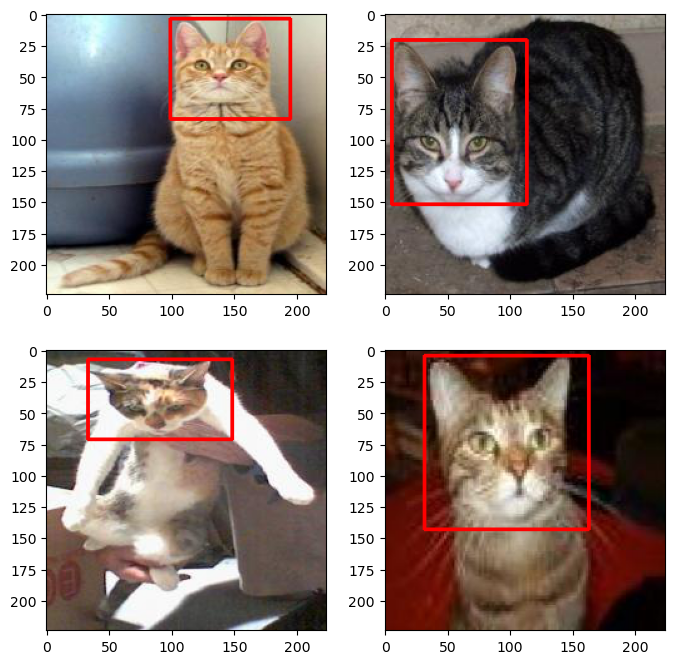

In [29]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_images[idx].copy(),
                        tuple(points[0]),
                        tuple(points[1]),
                        color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

In [31]:
# 읽어온 이미지와 바운딩 박스를 저장
np.savez('../save/cat_bbs.npz', images=dataset_images, bbs=dataset_bbs)

In [32]:
# 저장한 데이터를 다시 읽어옴

data = np.load('../save/cat_bbs.npz')
x_train = data['images']
y_train = data['bbs']

print(x_train.shape, y_train.shape)

(91, 224, 224, 3) (91, 4)


In [33]:
# 데이터 정규화

x_train_s = x_train / 255.0

In [34]:
# 모델 생성
# 전이 학습 -> 이미 학습된 모델을 가져와서 파인튜닝해 사용하는 방법
# MobileNetV2 -> 이미지 분류를 위해 학습된 모델
# include_top=False -> 마지막 레이어를 포함하지 않고 모델을 로드 (마지막 레이어 (분류기)는 우리가 사용할 데이터에 맞게 변경)
# classes=1000 -> 1000개의 클래스를 분류하는 모델, 우리는 좌표를 예측해야 하므로 4개의 클래스를 분류하는 모델로 변경
# classifier_activation='linear' -> 마지막 레이어의 활성화 함수를 선형으로 변경

from keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    classes=4,
    # classifier_activation='linear'
)
base_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


In [35]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [36]:
from keras import Sequential
from keras.layers import Dense, Flatten

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
_____________________________________

In [38]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [39]:
from keras.callbacks import ModelCheckpoint

ckpt_path = '../save/cat_bbs.ckpt'
ckpt_cb = ModelCheckpoint(ckpt_path, save_weights_only=True, save_best_only=True, verbose=1)

EPOCHS = 30
BATCH_SIZE = 16


history = model.fit(x_train_s, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.2,
                    callbacks=[ckpt_cb],
                    verbose=1
                    )

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 682.9461 - mse: 682.9461
Epoch 1: val_loss improved from inf to 627.83899, saving model to ../save/cat_bbs.ckpt
5/5 [==============================] - 3s 507ms/step - loss: 682.9461 - mse: 682.9461 - val_loss: 627.8390 - val_mse: 627.8390
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 432.7477 - mse: 432.7477
Epoch 2: val_loss improved from 627.83899 to 396.47211, saving model to ../save/cat_bbs.ckpt
5/5 [==============================] - 2s 436ms/step - loss: 432.7477 - mse: 432.7477 - val_loss: 396.4721 - val_mse: 396.4721
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 404.2062 - mse: 404.2062
Epoch 3: val_loss improved from 396.47211 to 215.16418, saving model to ../save/cat_bbs.ckpt
5/5 [==============================] - 2s 457ms/step - loss: 404.2062 - mse: 404.2062 - val_loss: 215.1642 - val_mse: 215.1642
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 323.382

In [40]:
model.load_weights(ckpt_path)

## 테스트 데이터

In [47]:
fnames = glob.glob('../data/BBRegression/test' + '/*.jpg')
x_test = []
for f in fnames:
    image = PIL.Image.open(f)
    arr = np.array(image)
    x_test.append(arr)
x_test = np.array(x_test)
x_test = x_test.astype('float32')/255.
y_pred = model.predict(x_test).astype('int')

print(x_test.shape, y_pred.shape)

1/1 [==============================] - 0s 95ms/step
(11, 224, 224, 3) (11, 4)


array([[[[0.33333334, 0.46666667, 0.40392157],
         [0.34117648, 0.4745098 , 0.4117647 ],
         [0.34901962, 0.48235294, 0.41960785],
         ...,
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255]],

        [[0.34509805, 0.47843137, 0.41568628],
         [0.3529412 , 0.4862745 , 0.42352942],
         [0.36078432, 0.49411765, 0.43137255],
         ...,
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255]],

        [[0.36078432, 0.49411765, 0.43137255],
         [0.36862746, 0.5019608 , 0.4392157 ],
         [0.3764706 , 0.50980395, 0.44705883],
         ...,
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255],
         [0.01568628, 0.01176471, 0.03137255]],

        ...,

        [[0.60784316, 0.49803922, 0.45490196],
         [0.61960787, 0.50980395, 0.46666667]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

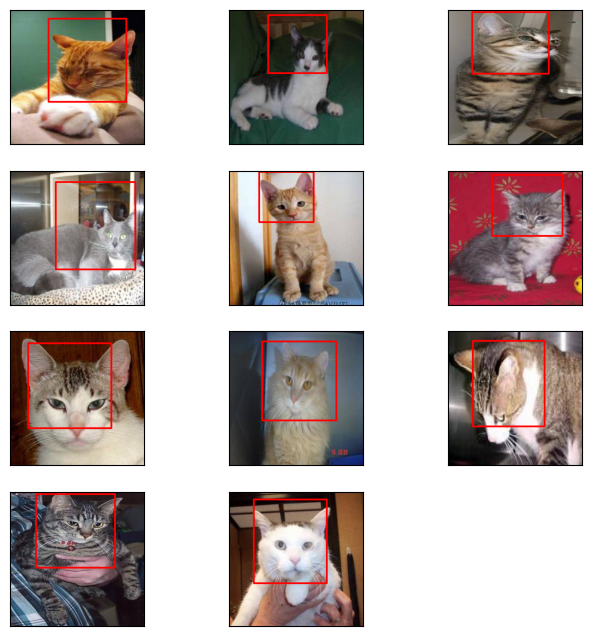

In [49]:
# samples = np.random.randint(11, size=4)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(range(11)):
    points = y_pred[idx].reshape(2, 2)
    img = cv2.rectangle(x_test[idx].copy(), tuple(points[0]),tuple(points[1]),color=(255, 0, 0),
                        thickness=2)
    plt.subplot(4, 3, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()